In [7]:
import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [3]:
df = pd.read_csv("Data/MGMT.csv")
df.head()

,files,labels,x,y
0,BraTS2021_00000,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
1,BraTS2021_00002,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
2,BraTS2021_00003,0,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
3,BraTS2021_00005,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
4,BraTS2021_00006,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...


In [4]:
files = list(df["files"].values)

In [4]:
def get_and_save_patches(brain, mask,  image_name, save_dir, target, patch_size=32, overlap=8):
    
    x_size = int((155 - patch_size)/overlap) + 1
    y_z_size = int((240 - patch_size)/overlap) + 1
    
    brain_patch_list = []
    mask_patches_list = []
    target_list = []
    pixels_in_brain_patch_list = []
    pixels_in_mask_patch_list = []
        
    for x in range(x_size):
        for y in range(y_z_size):
            for z in range(y_z_size):            
                
                brain_patch = brain[overlap*x:overlap*x + patch_size, overlap*y:overlap*y + patch_size, overlap*z:overlap*z + patch_size]
                mask_patch = mask[overlap*x:overlap*x + patch_size, overlap*y:overlap*y + patch_size, overlap*z:overlap*z + patch_size]
                   
                pixel_count = mask_patch.sum()
                
                if pixel_count >= 10:
                
                    pixels_in_mask_patch_list.append(pixel_count)           

                    pixel_count = brain_patch.astype(np.float64).sum()                
                    pixels_in_brain_patch_list.append(pixel_count)   

                    brain_patch_list.append(f"{save_dir}/{image_name}_{x}_{y}_{z}.h5")
                    mask_patches_list.append(f"{save_dir}/{image_name}_mask_{x}_{y}_{z}.h5")
                    target_list.append(target)            

                    with h5py.File(f'{save_dir}/{image_name}_{x}_{y}_{z}.h5', 'w') as hf:
                        hf.create_dataset("Slice",  data=brain_patch, chunks=True)
                    with h5py.File(f'{save_dir}/{image_name}_mask_{x}_{y}_{z}.h5', 'w') as hf:
                        hf.create_dataset("Slice",  data=mask_patch, chunks=True)
        
    df = pd.DataFrame(data={
        "brain_patches": brain_patch_list,
        "mask_patches": mask_patches_list,
        "pixels_in_brain_patch": pixels_in_brain_patch_list,
        "pixels_in_mask_patch": pixels_in_mask_patch_list,
        "target": target_list,
    })
    
    return df

In [6]:
df_saved = []

for i, f in enumerate(files):
    
    x = nib.load(df["x"].values[i]).get_fdata().astype(np.float16)
    x = x.transpose(2, 0, 1)

    y = nib.load(df["y"].values[i]).get_fdata().astype(np.uint8)
    y = y.transpose(2, 0, 1)

    target = df["labels"].values[i]
    
    path = f"Data/Patches_128X128X128/{f}"    
        
    if not os.path.exists(path):
    
        os.mkdir(path)

        df_patches = get_and_save_patches(x, y, f, path, target, 128)
        
        df_saved.append(df_patches)
                
    break
    
df_saved = pd.concat(df_saved).reset_index(drop=True)
        
df_saved.to_csv("Data/MGMT_3D_SLICES_128X128X128.csv", index=False)

In [7]:
df_saved.head()

,brain_patches,mask_patches,pixels_in_brain_patch,pixels_in_mask_patch,target
0,Data/Patches_128X128X128/BraTS2021_00000/BraTS...,Data/Patches_128X128X128/BraTS2021_00000/BraTS...,214906293.0,20722,1
1,Data/Patches_128X128X128/BraTS2021_00000/BraTS...,Data/Patches_128X128X128/BraTS2021_00000/BraTS...,243698287.0,20722,1
2,Data/Patches_128X128X128/BraTS2021_00000/BraTS...,Data/Patches_128X128X128/BraTS2021_00000/BraTS...,276954919.0,20722,1
3,Data/Patches_128X128X128/BraTS2021_00000/BraTS...,Data/Patches_128X128X128/BraTS2021_00000/BraTS...,312303142.0,20722,1
4,Data/Patches_128X128X128/BraTS2021_00000/BraTS...,Data/Patches_128X128X128/BraTS2021_00000/BraTS...,344218709.0,20722,1


### Size

In [86]:
# 573*5.9*df_saved.query("pixels_in_brain_patch > 0").shape[0]/df_saved.shape[0]

1789.7653034979423

In [78]:
# 573*5.9*df_saved.query("pixels_in_mask_patch > 0").shape[0]/df_saved.shape[0]

264.3345679012346

# Test saved patches

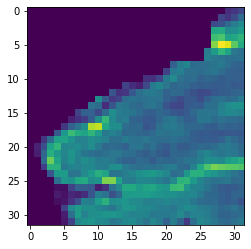

In [216]:
x_dir = df_saved["brain_patches"].values[0]

with h5py.File(x_dir, "r") as f:
    a_group_key = list(f.keys())[0]
    x = np.array(list(f[a_group_key]))
    
plt.imshow(x[30].astype(np.float32))
plt.show()

# Reconstruct patches

In [171]:
def create_mask_for_normalization(patch_size=32, overlap=8):
       
    mask = np.zeros((155, 240, 240))
    
    x_size = int((155 - patch_size)/overlap) + 1
    y_z_size = int((240 - patch_size)/overlap) + 1
    
    c = 0
        
    for x in range(x_size):
        for y in range(y_z_size):
            for z in range(y_z_size):            
                mask[overlap*x:overlap*x + patch_size, overlap*y:overlap*y + patch_size, overlap*z:overlap*z + patch_size] += np.ones((patch_size, patch_size, patch_size))
                                
                
    mask[mask == 0] = 1
    
    return mask 

In [172]:
mask_for_normalization = create_mask_for_normalization(patch_size=16)

In [173]:
def get_patches_from_input(input_image, patch_size=32, overlap=8):
    
    x_size = int((155 - patch_size)/overlap) + 1
    y_z_size = int((240 - patch_size)/overlap) + 1
    
    patches = []
    
        
    for x in range(x_size):
        for y in range(y_z_size):
            for z in range(y_z_size):            
                patch = input_image[overlap*x:overlap*x + patch_size, overlap*y:overlap*y + patch_size, overlap*z:overlap*z + patch_size]
                patches.append(patch)
                
    return patches

In [174]:
def recreate_brain_from_patches(patches, patch_size=32, overlap=8):
    
    reconstructed_image = np.zeros((2, 155, 240, 240))
    
    x_size = int((155 - patch_size)/overlap) + 1
    y_z_size = int((240 - patch_size)/overlap) + 1
        
    for i in range(2):
        c = 0
        for x in range(x_size):
            for y in range(y_z_size):
                for z in range(y_z_size):            
                    reconstructed_image[i, overlap*x:overlap*x + patch_size, overlap*y:overlap*y + patch_size, overlap*z:overlap*z + patch_size] = patches[c][0][i]
                    c = c + 1
                    
    reconstructed_image = reconstructed_image/mask_for_normalization
                
    return reconstructed_image

In [178]:
patches = get_patches_from_input(x, patch_size=120, overlap=12)
x_reconstructed = recreate_brain_from_patches(patches, patch_size=120, overlap=12)

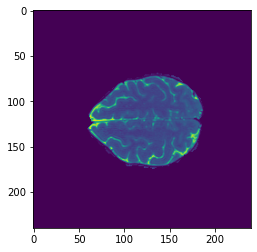

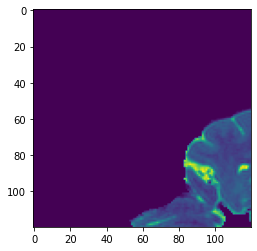

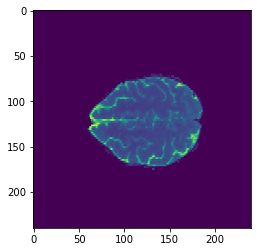

In [183]:
plt.imshow(x[120].astype(np.float32))
plt.show()

plt.imshow(patches[0][50].astype(np.float32))
plt.show()

plt.imshow(xr[0][120])
plt.show()